In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import math


**Analyze the raw dataset**

In [5]:
data = Dataset("K:/private/lorenzogamba,tomscag/CMIP6_2.6_projections_2022_2100_regridded_5deg.nc", 'r')

# print variables 
for var in data.variables:
    print(var)

lat = data.variables['lat']
lon = data.variables['lon']
time = data.variables['time']
dayofyear = data.variables['dayofyear']
tas = data.variables['tas']
height = data.variables['height']

print(lat)
print(lon)
print(time)
print(height) 
print(tas)
print(dayofyear)

height
lat
lon
tas
time
dayofyear
<class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    _FillValue: nan
    units: degrees_north
unlimited dimensions: 
current shape = (37,)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    _FillValue: nan
    units: degrees_east
unlimited dimensions: 
current shape = (72,)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    _FillValue: nan
    units: days since 2015-01-01
    calendar: proleptic_gregorian
    cell_methods: time: mean
unlimited dimensions: time
current shape = (28854,)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 height()
    _FillValue: nan
unlimited dimensions: 
current shape = ()
filling on
<class 'netCDF4._netCDF4.Variable'>
float32 tas(time, lat, lon)
    _FillValue: nan
    coordinates: height
    cell_methods: time: mean
unlimited dimensions: time
current shape = (28854, 37, 72)
filling on
<class 'netCDF4._netCDF4.Variable'>
int32 dayofyear(time)
unlimited dimensions: time
current

**Create the anomalies dataset**

In [8]:
src_file = "K:/private/lorenzogamba,tomscag/CMIP6_2.6_projections_2022_2100_regridded_5deg.nc"
dest_file = "C:/Users/David/OneDrive/Desktop/CLIMATE_NETWORK/data/anomalies_t2m_2022_2100_5grid_lowemission.nc"  # Modifica con il percorso desiderato

src_dataset = nc.Dataset(src_file, 'r')
dest_dataset = nc.Dataset(dest_file, 'r+')

# Copy dimensions
for dim_name, dim in src_dataset.dimensions.items():
    dest_dataset.createDimension(dim_name, (len(dim) if not dim.isunlimited() else None))

# Copy structur of variabiables
for var_name, var in src_dataset.variables.items():
    new_var = dest_dataset.createVariable(var_name, var.datatype, var.dimensions)
    # Copy attributes
    new_var.setncatts({attr: var.getncattr(attr) for attr in var.ncattrs()})
src_dataset.close()
dest_dataset.close()

**Anomalies dataset**

In [8]:
data = Dataset("C:\\Users\\David\\OneDrive\\Desktop\\CLIMATE_NETWORK\\data\\filtered_t2m_1970_2022_5grid.nc", 'r')

# print variables 
for var in data.variables:
    print(var)

lat = data.variables['lat']
lon = data.variables['lon']
t2m = data.variables['t2m']

print(lat)
print(lon)
print(t2m)

lat
lon
t2m
<class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
unlimited dimensions: 
current shape = (37,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
unlimited dimensions: 
current shape = (72,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 t2m(time, lat, lon)
unlimited dimensions: 
current shape = (19358, 37, 72)
filling on, default _FillValue of 9.969209968386869e+36 used


**Dask Client**

In [2]:
import dask.array as da
from dask.distributed import LocalCluster, Client
import dask

# Avviare il client Dask
cluster = LocalCluster(n_workers=24)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 24
Total threads: 24,Total memory: 31.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60261,Workers: 24
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 31.84 GiB
Comm: tcp://127.0.0.1:60366,Total threads: 1
Dashboard: http://127.0.0.1:60367/status,Memory: 1.33 GiB
Nanny: tcp://127.0.0.1:60264,


In [3]:
import math
import numpy as np
import os
from numpy.lib.stride_tricks import as_strided
import xarray as xr
from scipy.special import erfc 
import os
import matplotlib.pyplot as plt

def crosscorrelation(x, y, maxlag, normalize=True):
    """
    Cross correlation with a maximum number of lags, with optional normalization.

    Parameters:
    x, y: one-dimensional numpy arrays with the same length.
    maxlag: maximum lag for which the cross correlation is computed.
    normalize: if True, calculate the normalized cross-correlation.
    
    Returns:
    An array of cross-correlation values with length 2*maxlag + 1.
    
    Credits: 
    https://stackoverflow.com/questions/30677241/how-to-limit-cross-correlation-window-width-in-numpy
    
    """
    
    py = np.pad(y.conj(), 2*maxlag, mode='constant')
    T = as_strided(py[2*maxlag:], shape=(2*maxlag+1, len(y) + 2*maxlag),
                   strides=(-py.strides[0], py.strides[0]))
    px = np.pad(x, maxlag, mode='constant')

    
    cross_corr = T.dot(px)
    
    if normalize:
        # Subtract means
        mx = np.mean(x)
        my = np.mean(y)
        norm = float(len(y) * mx * my)

        # Compute the numerator as the sum of products of differences from means
        numerator = cross_corr - norm

        # Compute the denominator
        sigma_x = np.sqrt(np.sum((x - mx) ** 2))
        sigma_y = np.sqrt(np.sum((y - my) ** 2))
        denominator = float(sigma_x * sigma_y)
        
        # Normalize the cross-correlation
        cross_corr = numerator / denominator
    
    return cross_corr

def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371 # average radius

    # degree to radiant
    lat1_rad = lat1 * math.pi / 180
    lon1_rad = lon1 * math.pi / 180
    lat2_rad = lat2 * math.pi / 180
    lon2_rad = lon2 * math.pi / 180

    d_lat = lat2_rad - lat1_rad
    d_lon = lon2_rad - lon1_rad

    # haversine formula 
    a = math.sin(d_lat / 2) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(d_lon / 2) ** 2
    if a > 1:
        a = 1.0
        
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = radius * c

    return distance

def probabilityfrom(Z: float, dis: float) -> float:
    """
    Calculate probability based on the values of Z and dis.
    
    Parameters:
        Z (float): A parameter of the function.
        dis (float): Another parameter of the function.
        
    Returns:
        float: The calculated probability.
    """
    e = np.e
    
    # Calculate pval based on the value of Z
    #pval = np.where(Z < 1, 1, 1/(Z**2))
    pval = erfc(Z)
    # Compute B_value using the calculated pval
    B_value = np.where(pval < e**(-1), -e*pval*np.log(np.abs(pval)), 1)
    
    # Compute prior and prob values
    prior = np.exp(-dis/2000)
    prob = 1 - (1 + ((B_value) * (1-prior) / (prior))**(-1))**(-1)

    return prob

def analyze_chunk(data_chunk, nodes, max_lag, dec):

    zscores_array = np.zeros((37*72, 37*72))  
    timelag_array = np.zeros((37*72, 37*72))
    #prob_array = np.zeros((37*72, 37*72))


    for indi, nod in enumerate(nodes):
        Ai, Aj = nodes[indi]
        for indj, node in enumerate(nodes):
            (Bi, Bj) = nodes[indj]

            if indi < indj:
                cross_corr = crosscorrelation(data_chunk.values[:,Ai, Aj], data_chunk.values[:,Bi, Bj], max_lag)

                cmax = np.max(cross_corr)
                mean = np.mean(cross_corr) 
                std = np.std(cross_corr) 

                zscores_array[indj, indi] = (cmax-mean)/std
                
                lag_max = np.argmax(cross_corr)
                timelag_array[indi, indj] = lag_max

    #prob_array = probabilityfrom(zscores_array, distance_matrix)

    np.save(f'./Zscore 1970 2022/zscores_year_{dec}.npy', zscores_array)
    np.save(f'./Timelag 1970 2022/timelag_year_{dec}.npy', timelag_array)
    #np.save(f'./Networks 1970 2022/prob_year_{dec}.npy', prob_array)

if __name__ == "__main__":


    max_lag = 200         
    start_year = 1970
    end_year = 2022

    start_days = []
    
    current_day = 0  # 1 jan 2022
    for year in range(start_year, end_year + 1):
        
        start_days.append(current_day)
        if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
            days_in_year = 366
        else:
            days_in_year = 365
        current_day += days_in_year 
    last_day_index = 19358
    #last_day_index = 28854
    start_days.append(last_day_index) 


    # Dataset NetCDF

    ds = xr.open_dataset('C:\\Users\\David\\OneDrive\\Desktop\\CLIMATE_NETWORK\\Paper W\\filtered_t2m_1970_2022_5grid.nc')
    t2m = ds['t2m']
    lon = ds['lon']
    lat = ds['lat']

    # Nodes

    lon_range = range(0,len(lon))
    lat_range = range(0,len(lat))
    nodes = tuple((i,j) for i in lat_range for j in lon_range)

    
    # Distance Matrix

    '''distance_matrix = np.zeros((len(nodes), len(nodes)))
    for i, (lat1_index, lon1_index) in enumerate(nodes):
        #print(i)
        for j, (lat2_index, lon2_index) in enumerate(nodes):
            print(i, '   ', j)
            if j >= i:  # Questo assicura che calcoliamo solo la metà superiore
                lat1 = lat[lat1_index].item()  # Convert to Python scalar if it's an xarray DataArray
                lon1 = lon[lon1_index].item()
                lat2 = lat[lat2_index].item()
                lon2 = lon[lon2_index].item()
                
                distance = haversine_distance(lat1, lon1, lat2, lon2)
                distance_matrix[i, j] = distance
                distance_matrix[j, i] = distance  # Copia il valore nella metà opposta
    
    np.save('distance_matrix_grid5.npy', distance_matrix)'''
    #distance_matrix = np.load('distance_matrix_corrected.npy')
    
    # Dask Parallization
    '''data_chunk = t2m.isel(time=slice(start_days[2], start_days[2+1]))
    print(data_chunk[:, 1,3])

    for i in range(10):
        cross_corr_values = crosscorrelation(data_chunk[:, 4+i, 26], data_chunk[:, 13, 27], 200)

        time_indices = np.arange(len(cross_corr_values))

        # Disegna lo scatter plot
        plt.figure()
        plt.scatter(time_indices, cross_corr_values)
        plt.show()


        cmax = np.max(cross_corr_values)
        mean = np.mean(cross_corr_values) 
        std = np.std(cross_corr_values) 
                    
        lag_max = np.argmax(cross_corr_values)
        print(lag_max)
        print(cmax)
        print(mean)
        print(std)
        print((cmax-mean)/std)
    '''
    
    delayed_results = []
    for dec in range(len(start_days) - 1):  # -1 perché l'ultimo elemento in start_days non ha un periodo successivo
    #for dec in range():
        data_chunk = t2m.isel(time=slice(start_days[dec], start_days[dec+1]))
        delayed_results.append(dask.delayed(analyze_chunk)(data_chunk, nodes, max_lag, dec))
    
    # Dask Graph
    dask.visualize(*delayed_results, optimize_graph=True, filename='my_graph.svg')

    # Dask Compute
    computed_results = dask.compute(*delayed_results)

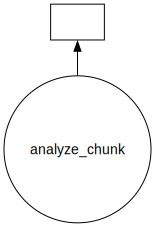

In [3]:
dask.visualize(*delayed_results, optimize_graph=True, filename='my_graph.svg')

In [8]:
from scipy.special import erfc
import os
import dask.array as da

def probabilityfrom(Z: float, dis: float) -> float:
    """
    Calculate probability based on the values of Z and dis.
    
    Parameters:
        Z (float): A parameter of the function.
        dis (float): Another parameter of the function.
        
    Returns:
        float: The calculated probability.
    """
    e = np.e
    
    # Calculate pval based on the value of Z
    #pval = np.where(Z < 1, 1, 1/(Z**2))
    pval = erfc(Z)
    # Compute B_value using the calculated pval
    B_value = np.where(pval < e**(-1), -e*pval*np.log(np.abs(pval)), 1)
    
    # Compute prior and prob values
    prior = np.exp(-dis/2000)
    prob = 1 - (1 + ((B_value) * (1-prior) / (prior))**(-1))**(-1)

    return prob


distance_matrix = np.load('distance_matrix_corrected_CMIP6.npy')


for dec in range(79):
#for dec in range(1):
    print(f'analyzing yr {dec}')
    z_scores_numpy = np.load(f'./Zscore 2022 2100/zscores_year_{dec}.npy')
    prob_array = np.empty_like(z_scores_numpy)

    prob_array = probabilityfrom(z_scores_numpy, distance_matrix)

    np.save(f'./Networks 2022 2100/fuzzy_year{2022+dec}.npy', prob_array)

analyzing yr 0


C:\Users\David\AppData\Local\Temp\ipykernel_3596\2907766485.py:26: RuntimeWarning: divide by zero encountered in reciprocal
  prob = 1 - (1 + ((B_value) * (1-prior) / (prior))**(-1))**(-1)


analyzing yr 1
analyzing yr 2
analyzing yr 3
analyzing yr 4
analyzing yr 5
analyzing yr 6
analyzing yr 7
analyzing yr 8
analyzing yr 9
analyzing yr 10
analyzing yr 11
analyzing yr 12
analyzing yr 13
analyzing yr 14
analyzing yr 15
analyzing yr 16
analyzing yr 17
analyzing yr 18
analyzing yr 19
analyzing yr 20
analyzing yr 21
analyzing yr 22
analyzing yr 23
analyzing yr 24
analyzing yr 25
analyzing yr 26
analyzing yr 27
analyzing yr 28
analyzing yr 29
analyzing yr 30
analyzing yr 31
analyzing yr 32
analyzing yr 33
analyzing yr 34
analyzing yr 35
analyzing yr 36
analyzing yr 37
analyzing yr 38
analyzing yr 39
analyzing yr 40
analyzing yr 41
analyzing yr 42
analyzing yr 43
analyzing yr 44
analyzing yr 45
analyzing yr 46
analyzing yr 47
analyzing yr 48
analyzing yr 49
analyzing yr 50
analyzing yr 51
analyzing yr 52
analyzing yr 53
analyzing yr 54
analyzing yr 55
analyzing yr 56
analyzing yr 57
analyzing yr 58
analyzing yr 59
analyzing yr 60
analyzing yr 61
analyzing yr 62
analyzing yr 63
a